# Homogenization

This notebook will solve a pin cell using continuous energy MC and generate 10 group MGXS over the entire homogenized universe.  A second MC simulation will then use the 10 group MGXS that were generated to solve the homogenized system.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import openmc

%matplotlib inline

In [2]:
# 1.6% enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_element('U', 1., enrichment=1.6)
fuel.add_element('O', 2.)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Zr', 1.)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_element('H', 4.9457e-2)
water.add_element('O', 2.4732e-2)
water.add_element('B', 8.0042e-6)

In [3]:
# Instantiate a Materials object
materials_file = openmc.Materials((fuel, zircaloy, water))

# Export to "materials.xml"
materials_file.export_to_xml()

In [4]:
# Create cylinders for the fuel and clad
# The x0 and y0 parameters (0. and 0.) are the default values for an
# openmc.ZCylinder object. We could therefore leave them out to no effect
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, r=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, r=0.45720)

# Create boundary planes to surround the geometry
min_x = openmc.XPlane(x0=-0.63, boundary_type='reflective')
max_x = openmc.XPlane(x0=+0.63, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.63, boundary_type='reflective')
max_y = openmc.YPlane(y0=+0.63, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')

In [5]:
# Create a Universe to encapsulate a fuel pin
fuel_pin_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
fuel_pin_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
fuel_pin_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
fuel_pin_universe.add_cell(moderator_cell)

In [6]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = fuel_pin_universe

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(name='root universe', universe_id=0)
root_universe.add_cell(root_cell)

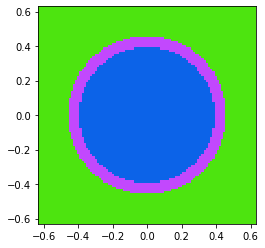

In [7]:
root_universe.plot(origin=(0., 0., 0.), width=(1.26, 1.26), pixels=(100, 100), color_by='material')

In [8]:
# Create Geometry and set root universe
geometry = openmc.Geometry(root_universe)

# Export to "geometry.xml"
geometry.export_to_xml()

In [9]:
# OpenMC simulation parameters
batches = 200
inactive = 50
particles = 10000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
#settings_file.output = {'tallies': False}
settings_file.run_mode = 'eigenvalue'
#settings_file.verbosity = 4

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.63, -0.63, -10, 0.63, 0.63, 10.]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

In [10]:
# Instantiate a 2-group EnergyGroups object
groups = openmc.mgxs.EnergyGroups((0.0, 0.058, 0.14, 0.28, 0.625, 4.0, 10.0, 40.0, 5530.0,
                                   0.821e6, 20.0e6))
#groups = openmc.mgxs.EnergyGroups([0., 0.625, 20.0e6])

In [11]:
# Initialize a 2-group MGXS Library for OpenMC
mgxs_lib = openmc.mgxs.Library(geometry)
mgxs_lib.energy_groups = groups

In [12]:
# Specify multi-group cross section types to compute
mgxs_lib.mgxs_types = ['total', 'absorption', 'nu-fission', 'fission',
                       'nu-scatter matrix', 'multiplicity matrix', 'chi']

In [13]:
# Specify a "cell" domain type for the cross section tally filters
mgxs_lib.domain_type = "universe"

# Specify the cell domains over which to compute multi-group cross sections
mgxs_lib.domains = [root_universe]

In [14]:
# Do not compute cross sections on a nuclide-by-nuclide basis
mgxs_lib.by_nuclide = False

In [15]:
# Set the Legendre order to 3 for P3 scattering
mgxs_lib.legendre_order = 3

/home/bforget/.local/lib/python3.8/site-packages/openmc/mgxs/library.py:418: RuntimeWarning: The P0 correction will be ignored since the scattering order 3 is greater than zero
  warn(msg, RuntimeWarning)


In [16]:
# Check the library - if no errors are raised, then the library is satisfactory.
mgxs_lib.check_library_for_openmc_mgxs()

In [17]:
# Construct all tallies needed for the multi-group cross section library
mgxs_lib.build_library()

In [18]:
# Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies_file, merge=True)
tallies_file.export_to_xml()

In [20]:
# Run OpenMC
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      130/1    1.14031    1.16275 +/- 0.00165
      131/1    1.16018    1.16272 +/- 0.00163
      132/1    1.16714    1.16277 +/- 0.00161
      133/1    1.14953    1.16261 +/- 0.00160
      134/1    1.15505    1.16252 +/- 0.00158
      135/1    1.13676    1.16222 +/- 0.00159
      136/1    1.15559    1.16214 +/- 0.00157
      137/1    1.15208    1.16203 +/- 0.00156
      138/1    1.16475    1.16206 +/- 0.00154
      139/1    1.16861    1.16213 +/- 0.00153
      140/1    1.17706    1.16230 +/- 0.00152
      141/1    1.17663    1.16246 +/- 0.00151
      142/1    1.16413    1.16247 +/- 0.00149
      143/1    1.17550    1.16261 +/- 0.00148
      144/1    1.19676    1.16298 +/- 0.00151
      145/1    1.16079    1.16295 +/- 0.00150
      146/1    1.15543    1.16288 +/- 0.00148
      147/1    1.17271    1.16298 +/- 0.00147
      148/1    1.16613    1.16301 +/- 0.00146
      149/1    1.18980    1.16328 +/- 0.00147
      150/1    1.18598    1.16351 +/- 0.00147
      151/1    1.14829    1.16336 

In [21]:
# Move the statepoint File
ce_spfile = './statepoint_ce.h5'
os.rename('statepoint.{}.h5'.format(batches), ce_spfile)
# Move the Summary file
ce_sumfile = './summary_ce.h5'
os.rename('summary.h5', ce_sumfile)

In [22]:
# Load the statepoint file
sp = openmc.StatePoint(ce_spfile, autolink=False)

# Load the summary file in its new location
su = openmc.Summary(ce_sumfile)
sp.link_with_summary(su)

From the tallies of the continuous energy MC simulation, we now generate a MGXS library for the root universe.

In [23]:
# Initialize MGXS Library with OpenMC statepoint data
mgxs_lib.load_from_statepoint(sp)

In [24]:
# Create a MGXS File which can then be written to disk
mgxs_file = mgxs_lib.create_mg_library(xs_type='macro', xsdata_names=['root'])

# Write the file to disk using the default filename of "mgxs.h5"
mgxs_file.export_to_hdf5()

We now create a new material that will use the MGXS library.

In [25]:
# Re-define our materials to use the multi-group macroscopic data
# instead of the continuous-energy data.

root_mg = openmc.Material(name='homogenized', material_id=1)
root_mg.add_macroscopic('root')

# Finally, instantiate our Materials object
materials_file = openmc.Materials([root_mg])

# Set the location of the cross sections file
materials_file.cross_sections = 'mgxs.h5'

# Export to "materials.xml"
materials_file.export_to_xml()

/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)


We turn on multigroup mode in the settings file.

In [26]:
# Set the energy mode
settings_file.energy_mode = 'multi-group'

# Export to "settings.xml"
settings_file.export_to_xml()

In [27]:
!rm geometry.xml
!rm tallies.xml

And then we create an homogenized version of the pin cell that will be assigned the homogenized 10 group MGXS material.

In [28]:
# Create boundary planes to surround the geometry
min_x = openmc.XPlane(x0=-0.63, boundary_type='reflective')
max_x = openmc.XPlane(x0=+0.63, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.63, boundary_type='reflective')
max_y = openmc.YPlane(y0=+0.63, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')

In [29]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = root_mg

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

In [30]:
# Create root Universe
root_universe = openmc.Universe(name='root universe', universe_id=0)
root_universe.add_cell(root_cell)

/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another UniverseBase instance already exists with id=0.
  warn(msg, IDWarning)


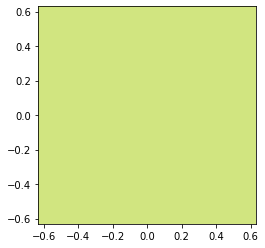

In [31]:
root_universe.plot(origin=(0., 0., 0.), width=(1.26, 1.26), pixels=(100, 100), color_by='material')

In [32]:
# Create Geometry and set root universe
geometry = openmc.Geometry(root_universe)

# Export to "geometry.xml"
geometry.export_to_xml()

In [33]:
# Run the Multi-Group OpenMC Simulation
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      159/1    1.16900    1.16246 +/- 0.00118
      160/1    1.16996    1.16253 +/- 0.00117
      161/1    1.17837    1.16267 +/- 0.00117
      162/1    1.16899    1.16273 +/- 0.00116
      163/1    1.18203    1.16290 +/- 0.00116
      164/1    1.15180    1.16280 +/- 0.00116
      165/1    1.18133    1.16296 +/- 0.00116
      166/1    1.20949    1.16336 +/- 0.00121
      167/1    1.14589    1.16321 +/- 0.00121
      168/1    1.16402    1.16322 +/- 0.00120
      169/1    1.17620    1.16333 +/- 0.00120
      170/1    1.15707    1.16328 +/- 0.00119
      171/1    1.17401    1.16336 +/- 0.00118
      172/1    1.17995    1.16350 +/- 0.00118
      173/1    1.14526    1.16335 +/- 0.00118
      174/1    1.18154    1.16350 +/- 0.00118
      175/1    1.14736    1.16337 +/- 0.00118
      176/1    1.15733    1.16332 +/- 0.00117
      177/1    1.16424    1.16333 +/- 0.00116
      178/1    1.16634    1.16335 +/- 0.00115
      179/1    1.17335    1.16343 +/- 0.00114
      180/1    1.17540    1.16352 

In [34]:
# Move the StatePoint File
mg_spfile = './statepoint_mg.h5'
os.rename('statepoint.' + str(batches) + '.h5', mg_spfile)
# Move the Summary file
mg_sumfile = './summary_mg.h5'
os.rename('summary.h5', mg_sumfile)

# Rename and then load the last statepoint file and keff value
mgsp = openmc.StatePoint(mg_spfile, autolink=False)

# Load the summary file in its new location
mgsu = openmc.Summary(mg_sumfile)
mgsp.link_with_summary(mgsu)

# Get keff
mg_keff = mgsp.k_combined

In [35]:
ce_keff = sp.k_combined

In [36]:
bias = 1.0E5 * (ce_keff - mg_keff)

print('Continuous-Energy keff = {0:1.6f}'.format(ce_keff))
print('Multi-Group keff = {0:1.6f}'.format(mg_keff))
print('difference [pcm]: {0:1.1f}'.format(bias.nominal_value))

Continuous-Energy keff = 1.163729+/-0.000683
Multi-Group keff = 1.163606+/-0.000407
difference [pcm]: 12.3


When we fully homogenize the system and generate MGXS, they will exactly reproduce (or within statistics when using MC) the perfect balance between neutron production and neutron sinks.  This is true regardless of the selected group structure!